
#  Авокадо

Хорошо известно, что миллениалы любят тосты с авокадо. Хорошо известно, что миллениалы живут со своими родителями. На самом деле они не могут купить себе дом, потому что едят слишком много тостов с авокадо. Но надежда есть. Если нам удастся найти город с дешёвым авокадо, миллениалы смогут туда переехать и накопить денег на собственные квартиры. В этом задании мы этим и займёмся!

In [6]:
# Поставим недостающий пакет
# !pip3 install sktime --ignore-installed

import sys
!{sys.executable} -m pip install --upgrade --force-reinstall sktime

  Using cached sktime-0.30.1-py3-none-any.whl (23.9 MB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Using cached packaging-24.1-py3-none-any.whl (53 kB)
  Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
  Using cached scikit_base-0.8.0-py3-none-any.whl (131 kB)
  Using cached scikit_learn-1.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
  Using cached scipy-1.13.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2023.4
    

In [7]:
import numpy as np
import pandas as pd

from scipy import stats

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

%matplotlib inline

In [8]:
import warnings
warnings.filterwarnings('ignore')

## Данные

Данные взяты [с соревнавания на kaggle.](https://www.kaggle.com/neuromusic/avocado-prices) В табличке ниже представлены месячные данные по розничной торговле авокадо:

* `Date` - дата наблюдения
* `AveragePrice` - средняя цена одного авокадо
* `Type` - обычный или органический
* `Year` - год
* `Region` - город или регион наблюдения

Кроме этих колонок есть ещё несколько технических, но они нас не будут интересовать.

In [9]:
dff = pd.read_csv('data/avocado_small.tsv', sep='\t', parse_dates=['Date']).set_index('Date')

# Периодичность данных - месячная
dff.index = dff.index.to_period("M")

# будем смотреть только на тип organic
dff = dff[dff.Type == 'organic']
print(dff.shape)
dff.head()

(2105, 4)


,AveragePrice,Region,Year,Type
Date,,,,
2015-12,1.84,Albany,2015,organic
2015-11,1.88,Albany,2015,organic
2015-10,1.98,Albany,2015,organic
2015-09,1.86,Albany,2015,organic
2015-08,2.00,Albany,2015,organic


Сразу же ответим на вопрос из шапки этой тетрадки и посмотрим как в разных городах цена на авокадо менялась год от года.

In [11]:
!pip3 install numpy==1.24.4
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 50.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have numpy 1.24.4 which is incompatible.


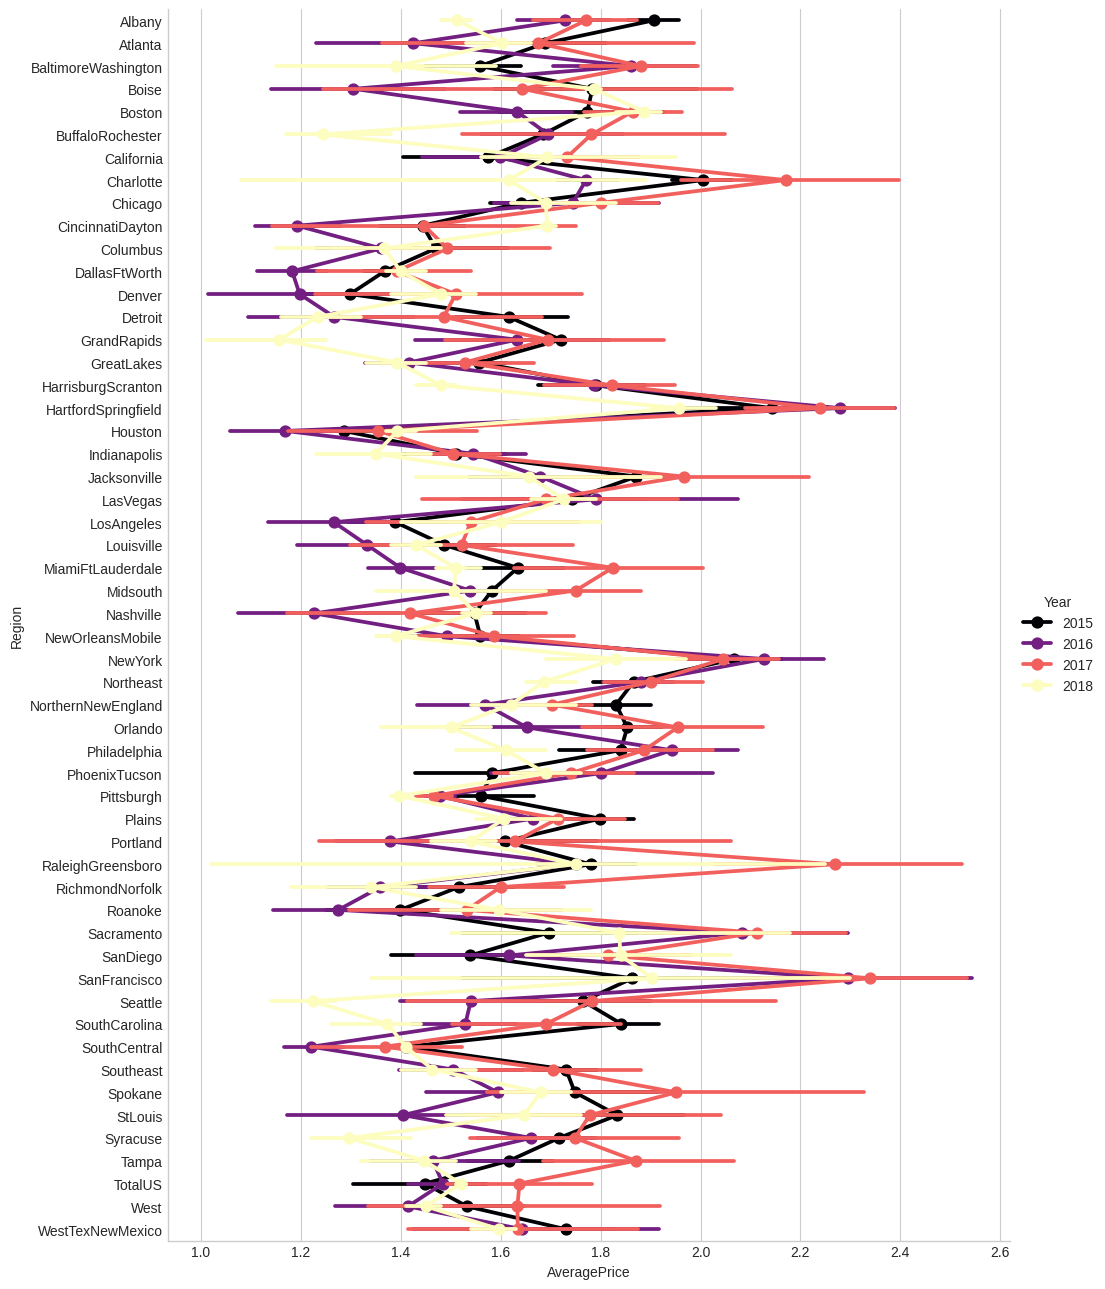

In [12]:

sns.catplot(x='AveragePrice', y='Region', data=dff, hue='Year',
            height=13, aspect=0.8, palette='magma', kind='point');

Кажется, что Сан-Франциско точно не подходит. Судя по всему, миллениалов может спасти Хьюстон.

In [13]:
df = dff[['AveragePrice', 'Region']]
df.head()

,AveragePrice,Region
Date,,
2015-12,1.84,Albany
2015-11,1.88,Albany
2015-10,1.98,Albany
2015-09,1.86,Albany
2015-08,2.00,Albany


In [14]:
df.index.unique().size # 39 уникальных точек (месячные данные)

39

In [15]:
df.Region.unique().size # 54 города

54

Будем работать с Бостоном. Разобьём выборку на трейн и тест. С помощью функции `plot_series`

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7aebe3057e20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so: cannot open shared object file: No such file or directory
Exception ignored on calling ctypes callback function: <function Thread

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Avocado Prices in Boston'}, ylabel='AveragePrice'>)

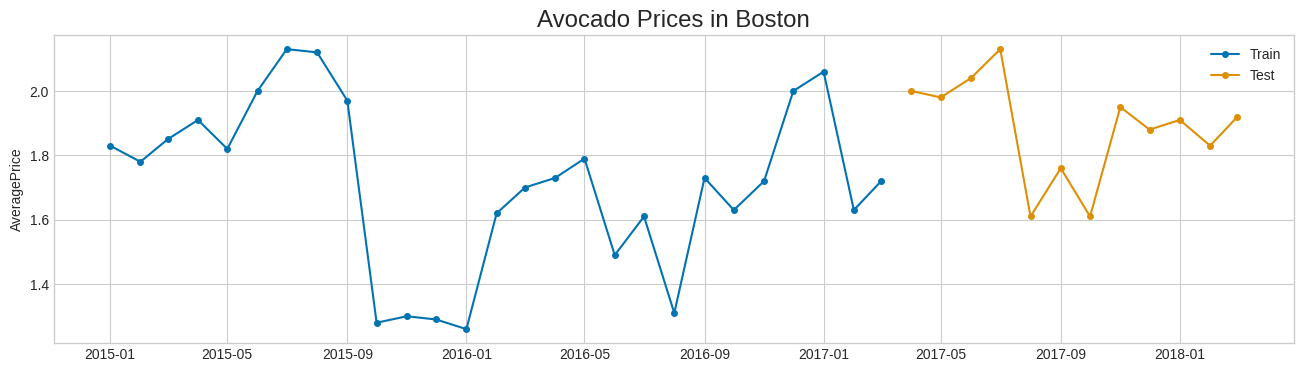

In [16]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

TEST_SIZE = 12
REGION = 'Boston'

y = df[df['Region'] == REGION].sort_index()['AveragePrice'].asfreq('m')

y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)

plot_series(y_train, y_test, labels=['Train', 'Test'], title='Avocado Prices in Boston')

In [17]:
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09',
             '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03'],
            dtype='period[M]', is_relative=False)

В качестве метрики качества будем использовать MAPE.

In [18]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 1. Прогнозы и ансамбль

__[а]__ Постройте наивный прогноз. Выберите из трёх стратегий для строительства наивного прогноза самую лучшую. Качество модели, полученной на тестовом периоде запишите в переменную `ans1`.

__Примечание:__ Cреднее для наивного прогноза считайте по окну размера`TEST_SIZE`.

In [19]:
from sktime.forecasting.naive import NaiveForecaster

### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

naive_last = NaiveForecaster(strategy="last")
naive_mean = NaiveForecaster(strategy="mean")
naive_seasonal_last = NaiveForecaster(strategy="last", sp=12)

naive_last.fit(y_train)
naive_mean.fit(y_train)
naive_seasonal_last.fit(y_train)

y_pred_last = naive_last.predict(fh)
y_pred_mean = naive_mean.predict(fh)
y_pred_seasonal_last = naive_seasonal_last.predict(fh)

mape_last = mape(y_test, y_pred_last)
mape_mean = mape(y_test, y_pred_mean)
mape_seasonal_last = mape(y_test, y_pred_seasonal_last)

best_mape = min(mape_last, mape_mean, mape_seasonal_last)

ans1 = best_mape

print(f"ans1 = {ans1}")

ans1 = 10.39037393153609


In [20]:
assert ans1  < 12

# несколько похожих скрытых тестов

best_approach = last


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='AveragePrice'>)

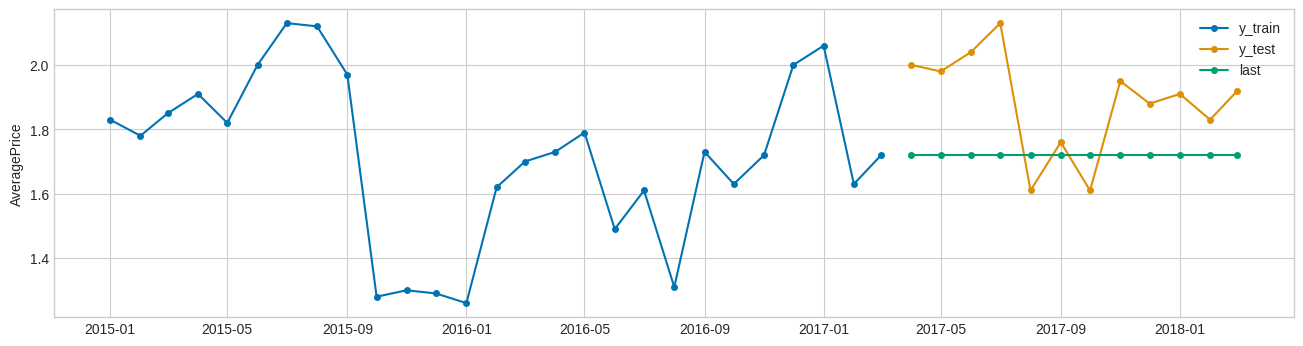

In [21]:
if best_mape == mape_last:
    best_approach = "last"
elif best_mape == mape_mean:
    best_approach = "mean"
else:
    best_approach = "seasonal_last"
print(f"best_approach = {best_approach}")

plot_series(y_train, y_test, y_pred_last, labels=['y_train', 'y_test', 'last'])

__[б]__  Используя `sm.tsa.statespace.ExponentialSmoothing` обучите $ETS(AAA)$ модель. Поставьте `seasonal=12`. Постройте доверительный интервал для прогнозов. Изобразите его на картинке. Найдите качество работы модели на тестовой выборке и запишите результат в переменную `ans2`. Удалось ли улучшить наивный прогноз?

In [22]:
import statsmodels.api as sm

### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

model = sm.tsa.statespace.ExponentialSmoothing(y_train, trend='add', seasonal=12).fit()
y_pred = model.forecast(len(y_test))
forecast_ci = model.get_forecast(len(y_test)).conf_int()
mape_ets = mape(y_test, y_pred)

ans2 = mape_ets
print(f"ans2 = {ans2}")

ans2 = 13.151970131888183


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Проведите диагностику модели. Правда ли, что остатки модели оказались нормальными? Можно ли использовать её для точечных прогнозов? Можно ли с её помощью строить для прогнозов надёжные доверительные интервалы?

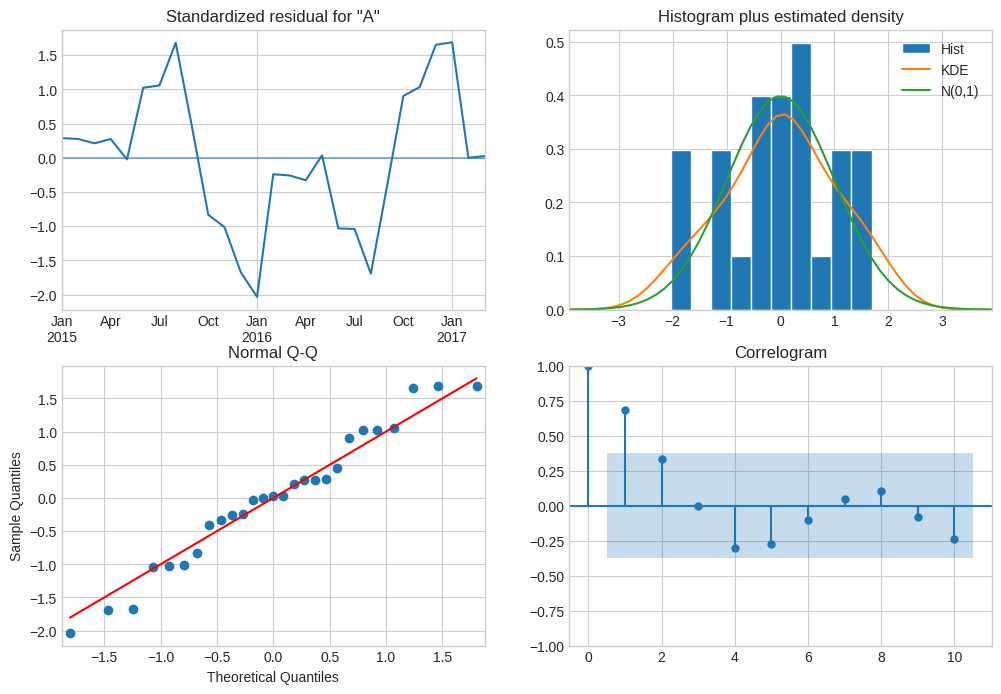

In [23]:
# your code here
# Проверка нормальности остатков

model.plot_diagnostics(figsize=(12, 8))
plt.show()

Точки достаточно апроксимируются прямой, то есть остатки распределены нормально.

In [24]:
assert ans2 < 15

# несколько похожих скрытых тестов

__[в]__  Попробуем новую для нас модель, $TBATS$. Это некоторое улучшение $ETS$, с тем как оно работает, мы будем разбиратться на следующей неделе. Пока просто обучим её и посмотрим на метрику качества. Запишите MAPE модели на тестовой выборке `ans3`. Не забудьте нарисовать картинку с динамикой прогнозов.

In [25]:
!pip install tbats --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.8 MB/s eta 0:00:00


In [26]:
from sktime.forecasting.tbats import TBATS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

forecaster = TBATS(sp=12,
                   use_trend=True,
                   use_damped_trend=True,
                   use_arma_errors=True,
                   use_box_cox=True)

### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

In [27]:
ans3 = mape(y_test, y_pred)
print(f"ans3 = {ans3}")

ans3 = 8.689743218672234


In [28]:
assert ans3 < 10

# несколько похожих скрытых тестов

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='AveragePrice'>)

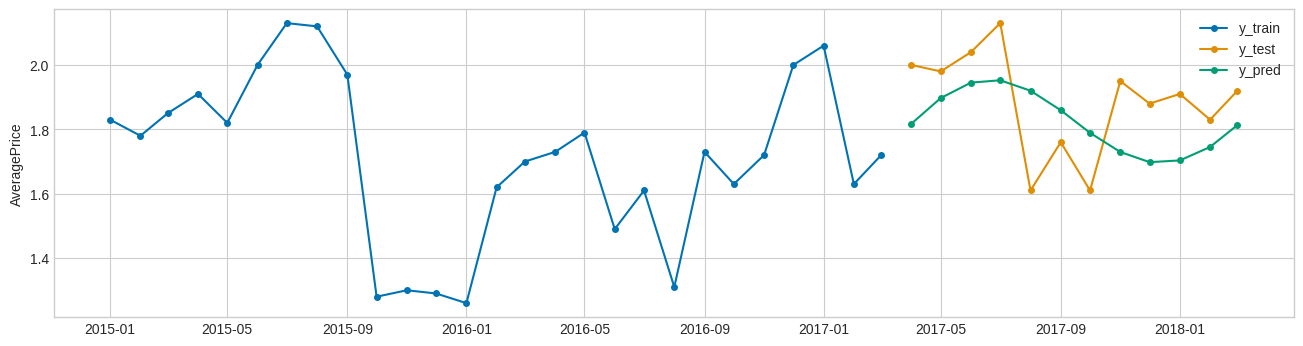

In [29]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

__[г]__ Попробуем заключительную модель перед ансамблем, тетта-метод. В переменную `ans4` запишите получившеесся MAPE.

In [30]:
from sktime.forecasting.theta import ThetaForecaster
forecaster = ThetaForecaster(sp=12)

### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

forecaster.fit(y_train)
y_pred_theta = forecaster.predict(fh)

ans4 = mape(y_test, y_pred_theta)
print(f"ans4 = {ans4}")

ans4 = 20.31600269689937


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='AveragePrice'>)

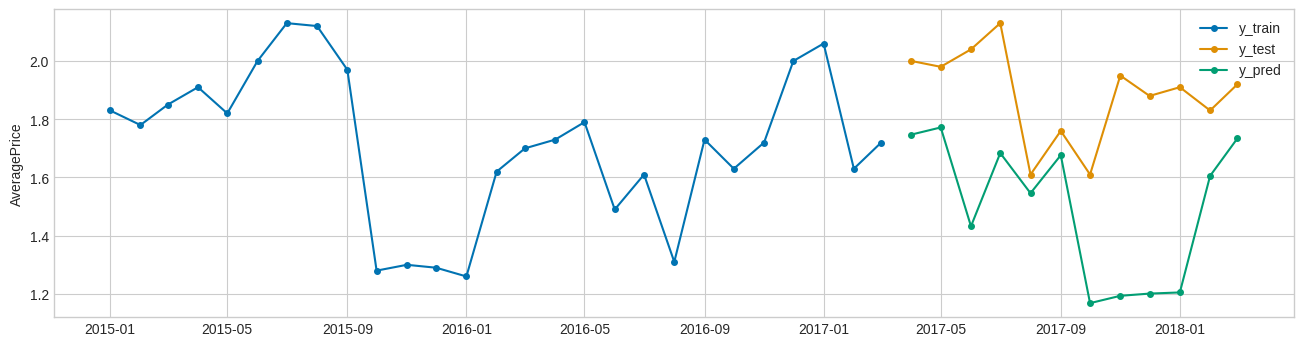

In [31]:
plot_series(y_train, y_test, y_pred_theta, labels=["y_train", "y_test", "y_pred"])

In [32]:
assert ans4 > 18

# несколько похожих скрытых тестов

__[д]__ Объединим все оценённые нами модели в ансамбль. Заполните недостающие части кода. В качестве `ans5` запишите MAPE для ансамбля. Удалось ли с помощью него получить хорошее качество?

In [33]:
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing


### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

forecaster = EnsembleForecaster(
    [("ets",   ExponentialSmoothing(trend="add", seasonal="add", sp=12)),
     ("tbats", TBATS(sp=12,
                   use_trend=True,
                   use_damped_trend=True,
                   use_arma_errors=True,
                   use_box_cox=True)),
     ("theta", ThetaForecaster(sp=12))
    ]
)

forecaster.fit(y_train)
pred_ansamble = forecaster.predict(fh)

In [34]:
ans5 = mape(pred_ansamble, y_test)
print(f"ans5 = {ans5}")

ans5 = 15.550654760062175


In [35]:
assert ans5 > 10

# несколько похожих скрытых тестов

> __ВАЖНО!!!__ Перед отправкой тетрадки в грейдер на оценивание закомментируйте код, который обучает модели. Оставьте только ответы, записанные в соотвествующие переменные. При выставлении оценки ваш код должен отрабатывать за 30 секунд. Из-за того, что модель обучается довольно долго, полноценный код процедуру тестирования не пройдёт.

# 2. Кросс-валидация

Понятное дело, что просто разбить выборку на трэйн и тест, а затем построить прогноз на всю тестовую часть - мало. Такие оценки качества моделей не очень стабильны. Более того, при прогнозировании на разные горизонты, мы получаем разные ошибки.

Для кросс-валидации будем использовать класс [SlidingWindowSplitter,](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.model_selection.SlidingWindowSplitter.html#sktime.forecasting.model_selection.SlidingWindowSplitter) в рамках которого реализовано скользящее окно. В тестовой выборке будем держать три месяца.

На семинаре мы использовали средства sklearn, но sktime на порядок удобнее.

In [36]:
from sktime.forecasting.model_selection import SlidingWindowSplitter

# параметры для кросс-валидации
window_length = 27                     # y_train.size
fh = ForecastingHorizon([1, 2, 3])     # максимум на 3 месяца вперёд
fh_length = len(fh)                    # даты для тестовой выборки

cv_window = SlidingWindowSplitter(window_length=window_length, fh=fh, start_with_window=True)

n_splits = cv_window.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 10


Выглядеть наше разбиение будет вот таким образом. Голубое - обучающая выборка, оранжевое - тестовая. Найти код для строительства такой картинки можно [в документации.](https://github.com/alan-turing-institute/sktime/blob/master/examples/window_splitters.ipynb) Там же описано много других стратегий кросс-валидации, уже реализованных в рамках пакета.

![](split.png)

Попробуем провести кросс-валидацию для Тетта-метода. Допишите в функции ниже нехватающие для этого части.

In [37]:
def mape(y_true, y_pred):
    return np.abs((y_true - y_pred) / y_true)* 100

def cross_val_sccore(forecaster, y, cv=cv_window):
    M = [ ]

    for idx_train, idx_val in cv.split(y):

        y_tr = y[idx_train]
        y_val = y[idx_val]
        fh_val = ForecastingHorizon(y_val.index, is_relative=False)

        # обучение модели

        forecaster.fit(y_tr)
        y_pred = forecaster.predict(fh_val)

        # your code here


        M.append(mape(y_val, y_pred).values)

    return np.array(M)

M = cross_val_sccore(ThetaForecaster(sp=12), y)
quality = M.mean(axis=0)
quality

array([11.08963128, 14.67886754, 14.9084376 ])

В векторе quality записано три различных значения MAPE нашей модели при прогнозировании на месяц, два и три вперёд.

In [38]:
assert M.shape == (10, 3) # это не тест на оценку, его можно закоментить при отправке в грейдер

Проведите кросс-валидацию для всех моделей из списка ниже. Какая из них показывает наилучший результат? В переменную `ans6` запишите номер модели, которая лучше всего прогноизрует на месяц вперёд. В перемменную `ans7` запишите номер модели, которая лучше всего прогнозирует на три месяца вперёд. Провизуализируйте получившееся качество на картинке по аналогии с семинаром.

In [39]:
from sktime.forecasting.ets import AutoETS

forecaster_1 = NaiveForecaster(strategy="last")
forecaster_2 = NaiveForecaster(strategy="mean", window_length=12)
forecaster_3 = NaiveForecaster(strategy="last", sp=12)

forecaster_4 = ThetaForecaster(sp=12)
forecaster_5 = AutoETS(auto=True, sp=12, n_jobs=-1, information_criterion='bic')

forecaster_6 = TBATS(sp=12,
                   use_trend=True,
                   use_damped_trend=True,
                   use_arma_errors=True,
                   use_box_cox=True)

forecasters = [forecaster_1, forecaster_2, forecaster_3, forecaster_4, forecaster_5, forecaster_6]

mape_scores = np.zeros((len(forecasters), len(fh)))

for forcstr in forecasters:
    m = cross_val_sccore(forcstr, y)
    print(str(forcstr), m.mean(axis=0)[0], m.mean(axis=0)[2])


# Определение наилучших моделей для каждого горизонта прогнозирования
best_models_1 = np.argmin(mape_scores[:, 0])
best_models_3 = np.argmin(mape_scores[:, 2])

ans6 = best_models_1 + 1
ans7 = best_models_3 + 1

print(f"ans6 = {ans6}")
print(f"ans7 = {ans7}")

NaiveForecaster() 9.504424601787951 14.114454773399924
NaiveForecaster(strategy='mean', window_length=12) 10.056733962788744 7.315006007076358
NaiveForecaster(sp=12) 12.208146496128949 12.03311337806304
ThetaForecaster(sp=12) 11.089631281776494 14.9084376010374
AutoETS(auto=True, information_criterion='bic', n_jobs=-1, sp=12) 8.78054390488009 12.965998063482775
TBATS(sp=12, use_box_cox=True, use_damped_trend=True, use_trend=True) 10.352422178822632 8.886307533270244
ans6 = 1
ans7 = 1


In [40]:
assert ans6 > 0
assert ans7 > 0
assert ans6 < 7
assert ans7 < 7

# несколько похожих скрытых тестов

> __ВАЖНО!!!__ Перед отправкой тетрадки в грейдер на оценивание закомментируйте код, который обучает модели. Оставьте только ответы, записанные в соотвествующие переменные. При выставлении оценки ваш код должен отрабатывать за 30 секунд. Из-за того, что модель обучается довольно долго, полноценный код процедуру тестирования не пройдёт.

# Необязательное задание:

1. Попробуйте прогнать наш пайплайн на всех городах. Найдите модель, которая побеждает в качестве прогноза чаще всего.

2. Прочитайте [туториал от sktime,](https://nbviewer.jupyter.org/github/alan-turing-institute/sktime/blob/master/examples/01_forecasting.ipynb) в нём вы найдёте пример того как делать Griidsearch, а также онлайн-прогнозирование с постепенно сдвигающимся окном. Попробуйте добавить в наш пайплайн [другие модели](https://www.sktime.org/en/latest/api_reference.html#sktime-forecasting-time-series-forecasting) и сравнить их между собой. Можно попробовать добавить `Autoarima`, `Prophet`, `KNeighborsRegressor`. Обязательно посстарайтесь разобраться, как именно они строят свой прогноз. Если не выходит, приходите на форум, будем разбираться вместе!

2. На гите библиотеки [есть довольно много примеров кода.](https://github.com/alan-turing-institute/sktime/tree/master/examples)

 ## Разбираемся в теории:

В этом задании вы встретились с таким алгоритмом, как Тетта-метод. Его придумали в $2000$ году и он довольно простой. Попробуйте [самостоятельно разобраться с ним](https://robjhyndman.com/papers/Theta.pdf) по аналогии с тем, как мы на лекциии разбирали другие модели:

 1. Выпишите уравнение модели
 2. Разбиритесь как строится точечный прогноз
 3. Разберитессь как строится доверительный интервал
 4. Придумайте простую задачку с цифрами, из 5 наблюдений, и решите её на листочке
